In [1]:
import sys
sys.path.append("../lib/")
import os
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from raman_lib.visualization import (plot_spectra_peaks, 
                                     plot_qc_summary, 
                                     plot_confidence_scores, 
                                     plot_coefs, 
                                     plot_confusion_matrix, 
                                     plot_roc_curve, 
                                     plot_val_curves, 
                                     plot_params,
                                     plot_roc_comparison,
                                     boxplot_comparison)

# Setup

In [2]:
dataset = "L_540_2022_C_E"

In [3]:
results_path = Path("../results/") / dataset

In [4]:
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))

y, y_key = pd.factorize(data.label)

In [5]:
rocs = {}
aucs = {}
p_vals = {}
accs = {}
f1_scores = {}
fit_times = {}
predict_times = {}

# Quality Control

In [6]:
qc_results = pd.read_csv(results_path / (dataset + "_qc_scores.csv"))

qc_results.describe()

,Median Height,N Peaks
count,644.000000,644.000000
mean,498.200599,11.899068
std,408.420793,7.186305
min,0.000000,0.000000
25%,251.798928,5.750000
50%,376.508668,13.000000
75%,615.551223,18.000000
max,3384.882113,27.000000


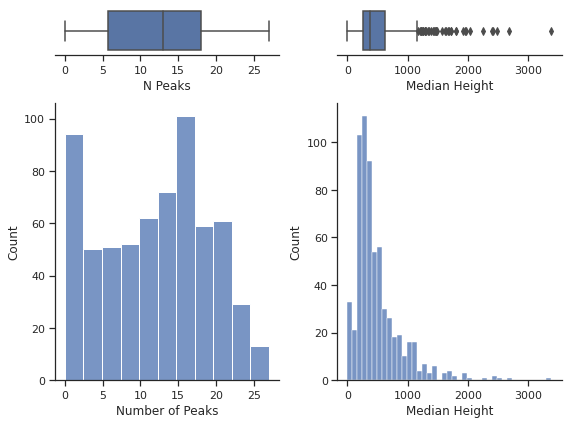

In [7]:
plot_qc_summary(qc_results)

# Dimensionality Reduction
## LDA
### Overview

In [8]:
current_path = results_path / "lda_dim_reduction/lda/"
name = "LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.0,2.000000,2.0,2.000000,2.0,2.000000,2.000000,2.000000,2.000000e+00
mean,1.0,0.678333,1.0,0.686790,1.0,0.726333,0.225499,0.002029,2.784003e-09
std,0.0,0.002357,0.0,0.007945,0.0,0.011471,0.015490,0.000355,4.477236e-10
min,1.0,0.676667,1.0,0.681172,1.0,0.718222,0.214546,0.001778,2.467414e-09
25%,1.0,0.677500,1.0,0.683981,1.0,0.722278,0.220022,0.001904,2.625709e-09
50%,1.0,0.678333,1.0,0.686790,1.0,0.726333,0.225499,0.002029,2.784003e-09
75%,1.0,0.679167,1.0,0.689599,1.0,0.730389,0.230975,0.002155,2.942297e-09
max,1.0,0.680000,1.0,0.692408,1.0,0.734444,0.236452,0.002281,3.100591e-09


### Confidence scores by class

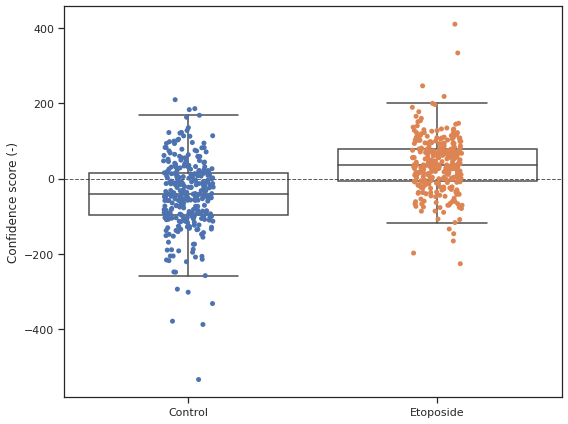

In [9]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

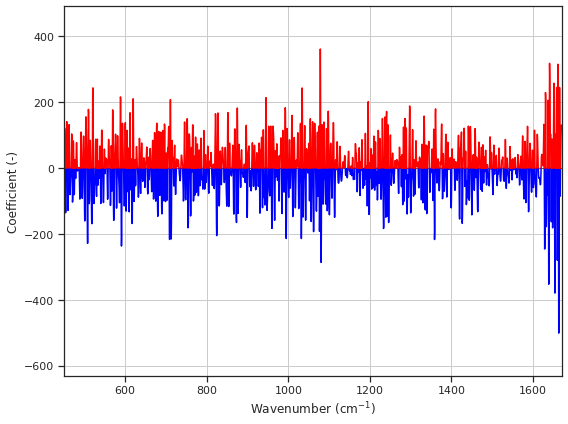

In [10]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)")

### Confusion Matrix

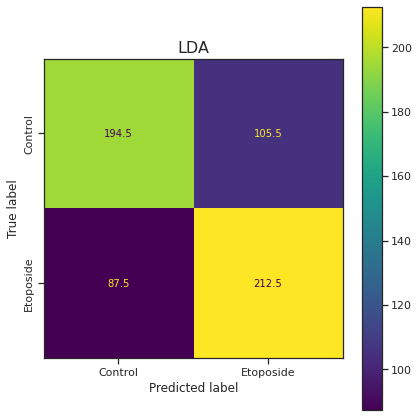

In [11]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

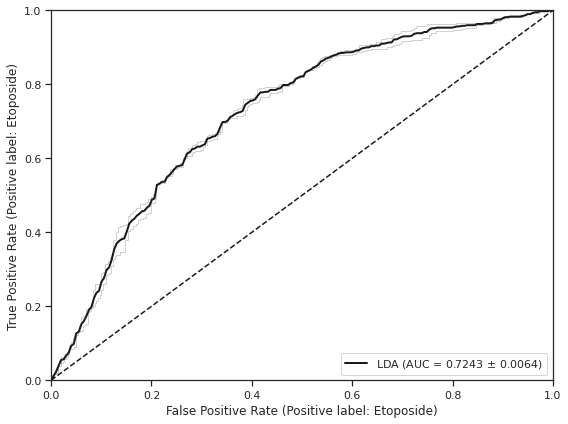

In [12]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## PCA-LDA
### Overview

In [13]:
current_path = results_path / "lda_dim_reduction/pca_lda/"
name = "PCA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
mean,0.881042,0.855833,0.882267,0.857647,0.956427,0.940028,1.726705,0.002896,4.677507e-31
std,0.000884,0.022392,0.001651,0.022524,0.000894,0.007975,0.012662,0.000011,6.614982e-31
min,0.880417,0.840000,0.881099,0.841720,0.955795,0.934389,1.717752,0.002888,8.648341e-37
25%,0.880729,0.847917,0.881683,0.849684,0.956111,0.937208,1.722229,0.002892,2.338758e-31
50%,0.881042,0.855833,0.882267,0.857647,0.956427,0.940028,1.726705,0.002896,4.677507e-31
75%,0.881354,0.863750,0.882850,0.865610,0.956743,0.942847,1.731182,0.002900,7.016256e-31
max,0.881667,0.871667,0.883434,0.873574,0.957059,0.945667,1.735659,0.002903,9.355005e-31


### Validation Curve

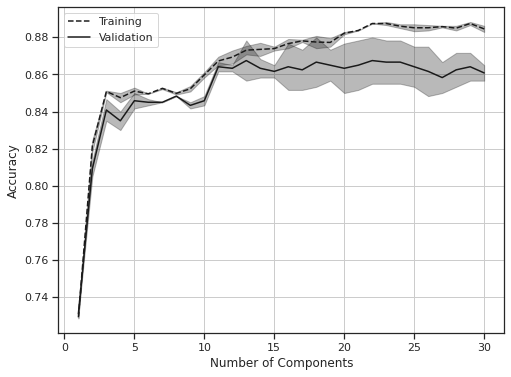

In [14]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Number of Components", y_label="Accuracy")

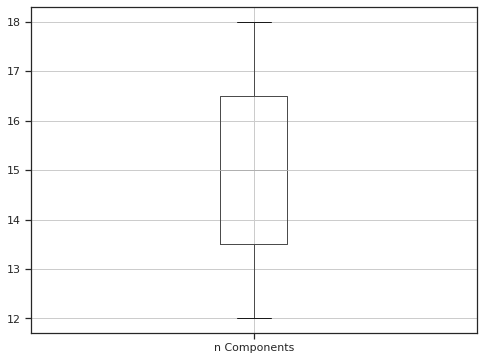

In [15]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

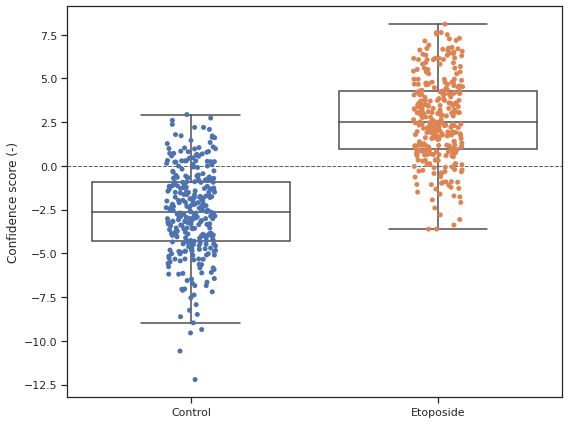

In [16]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

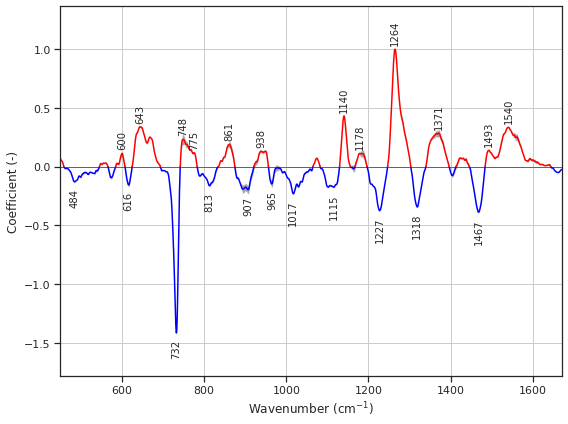

In [17]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

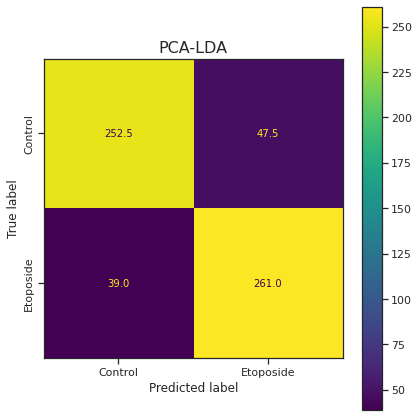

In [18]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

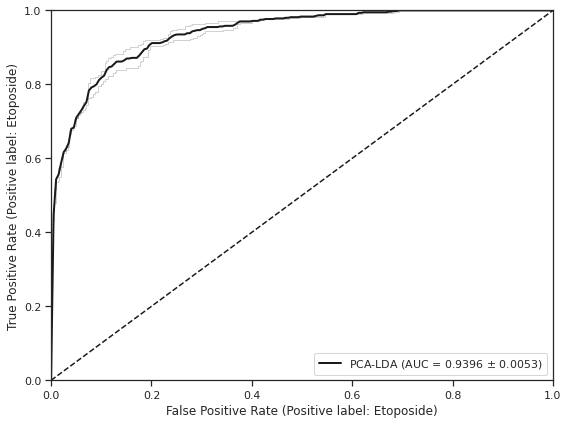

In [19]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## NMF-LDA
### Overview

In [20]:
current_path = results_path / "lda_dim_reduction/nmf_lda/"
name = "NMF-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
mean,0.884583,0.853333,0.885792,0.856054,0.956432,0.934472,8.346199,0.010136,1.462809e-32
std,0.011785,0.007071,0.012469,0.008827,0.004550,0.003496,0.261347,0.000487,1.671503e-32
min,0.876250,0.848333,0.876975,0.849812,0.953215,0.932000,8.161399,0.009792,2.808771e-33
25%,0.880417,0.850833,0.881384,0.852933,0.954824,0.933236,8.253799,0.009964,8.718428e-33
50%,0.884583,0.853333,0.885792,0.856054,0.956432,0.934472,8.346199,0.010136,1.462809e-32
75%,0.888750,0.855833,0.890201,0.859175,0.958041,0.935708,8.438599,0.010308,2.053774e-32
max,0.892917,0.858333,0.894609,0.862296,0.959649,0.936944,8.530999,0.010481,2.644740e-32


### Validation Curve

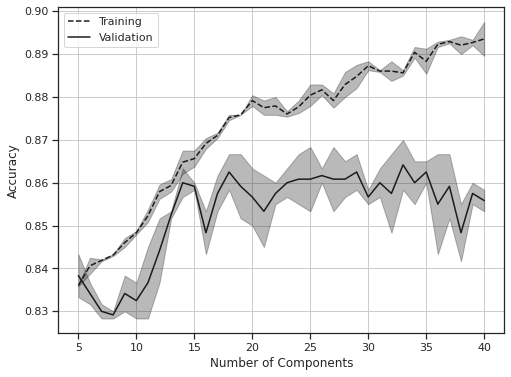

In [21]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Number of Components", y_label="Accuracy")

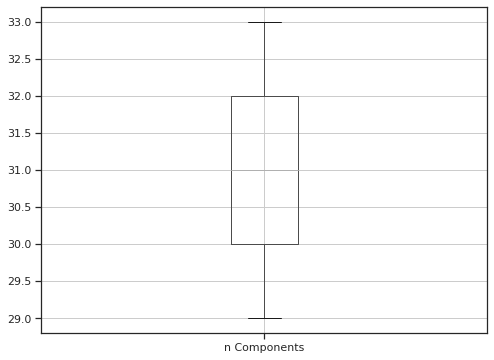

In [22]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

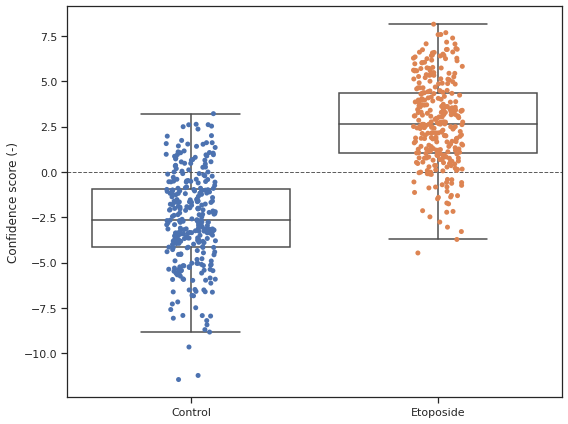

In [23]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

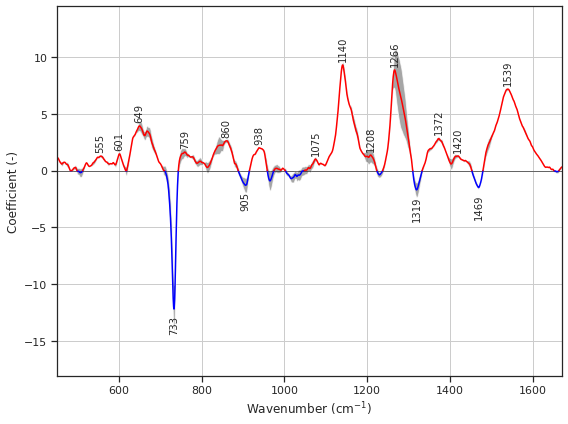

In [24]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=1, min_dist=50)

### Confusion Matrix

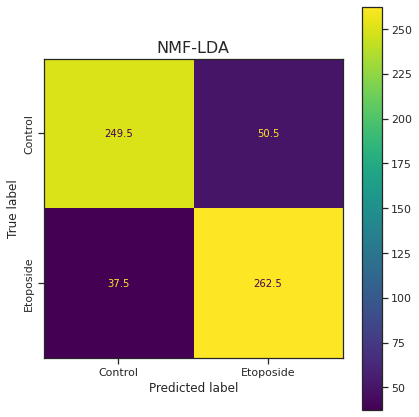

In [25]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

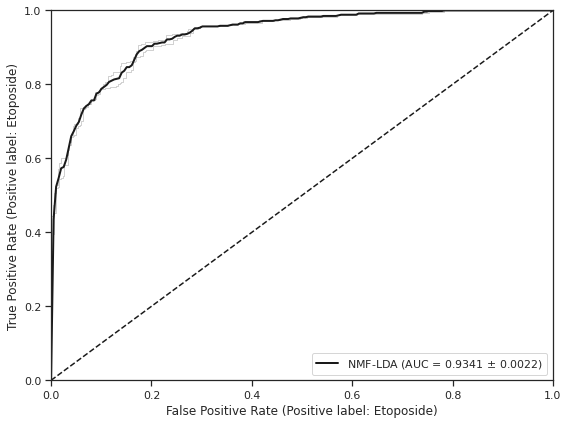

In [26]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Feature Agglomeration (FA) - LDA
### Overview

In [27]:
current_path = results_path / "lda_dim_reduction/fa_lda/"
name = "FA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
mean,0.871042,0.860833,0.869281,0.858139,0.945865,0.934361,2.867662,0.002906,9.365488e-36
std,0.002652,0.008250,0.002835,0.009975,0.000309,0.008996,0.015306,0.000020,1.291385e-35
min,0.869167,0.855000,0.867277,0.851086,0.945646,0.928000,2.856839,0.002892,2.340138e-37
25%,0.870104,0.857917,0.868279,0.854613,0.945755,0.931181,2.862250,0.002899,4.799751e-36
50%,0.871042,0.860833,0.869281,0.858139,0.945865,0.934361,2.867662,0.002906,9.365488e-36
75%,0.871979,0.863750,0.870284,0.861666,0.945974,0.937542,2.873073,0.002913,1.393123e-35
max,0.872917,0.866667,0.871286,0.865193,0.946083,0.940722,2.878484,0.002921,1.849696e-35


### Validation Curve

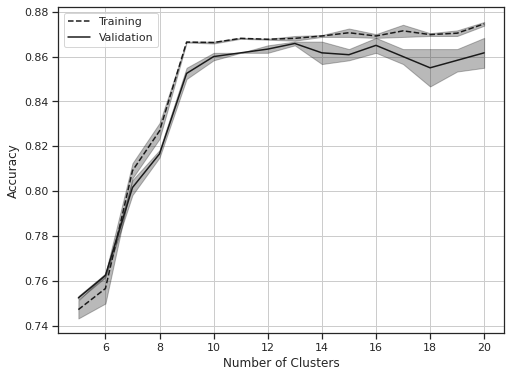

In [28]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Number of Clusters", y_label="Accuracy")

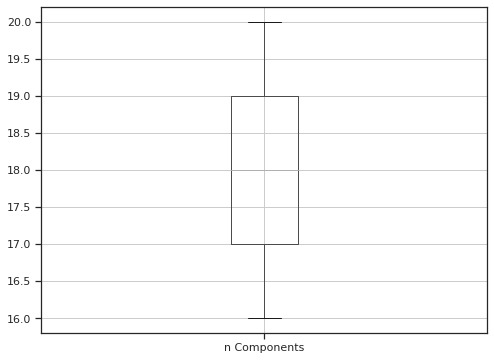

In [29]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

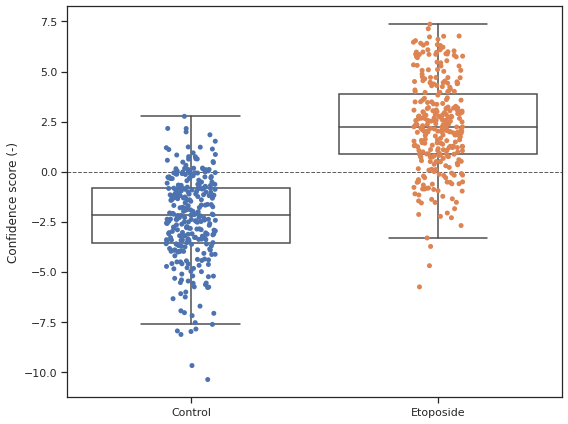

In [30]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

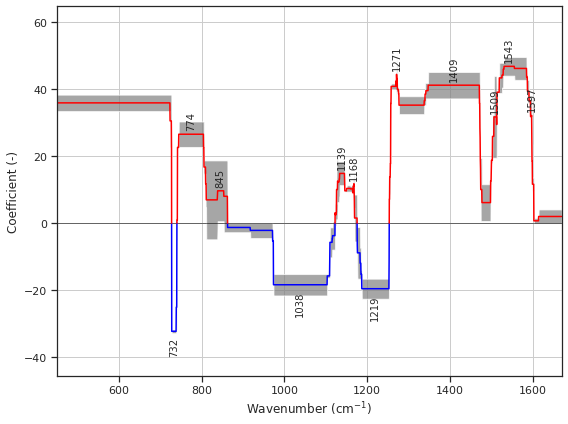

In [31]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=1, min_dist=50)

### Confusion Matrix

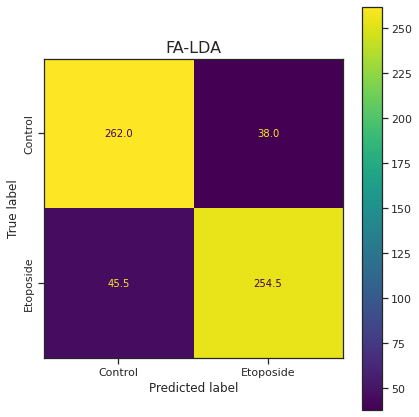

In [32]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

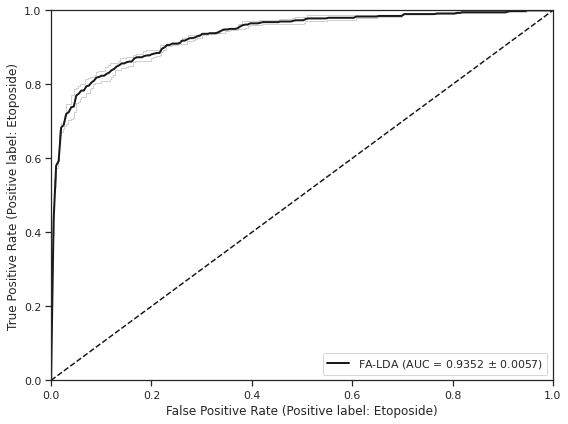

In [33]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Peak-LDA
### Overview

In [34]:
current_path = results_path / "lda_dim_reduction/peak_lda/"
name = "Peak-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00,2.000000e+00
mean,0.882083,0.875000,0.881873,0.874884,0.948189,0.939583,0.278474,1.128483e-03,4.642617e-36
std,0.001768,0.014142,0.001246,0.013051,0.000400,0.006639,0.017157,6.069146e-07,6.565556e-36
min,0.880833,0.865000,0.880992,0.865656,0.947906,0.934889,0.266342,1.128054e-03,6.814741e-41
25%,0.881458,0.870000,0.881432,0.870270,0.948048,0.937236,0.272408,1.128268e-03,2.321343e-36
50%,0.882083,0.875000,0.881873,0.874884,0.948189,0.939583,0.278474,1.128483e-03,4.642617e-36
75%,0.882708,0.880000,0.882313,0.879498,0.948331,0.941931,0.284539,1.128697e-03,6.963892e-36
max,0.883333,0.885000,0.882754,0.884112,0.948472,0.944278,0.290605,1.128912e-03,9.285167e-36


### Validation Curve

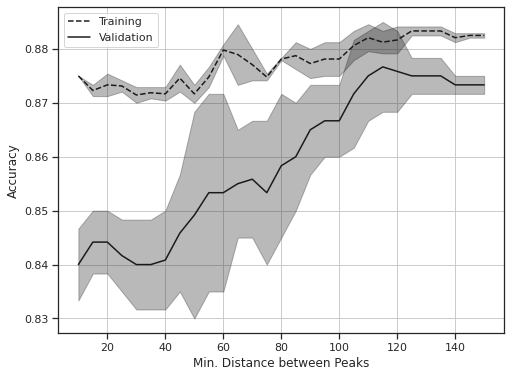

In [35]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Min. Distance between Peaks", y_label="Accuracy")

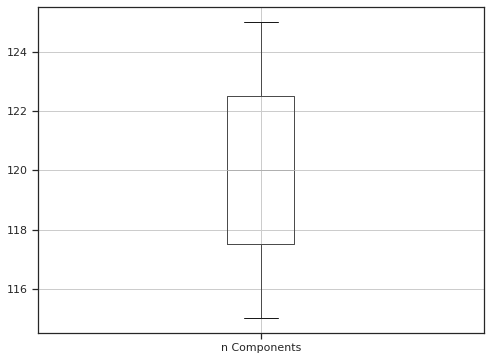

In [36]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

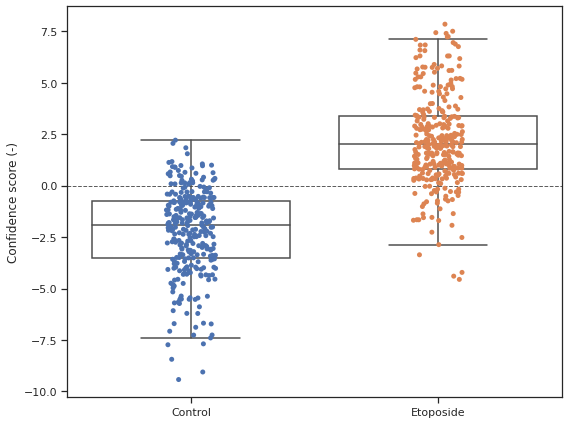

In [37]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

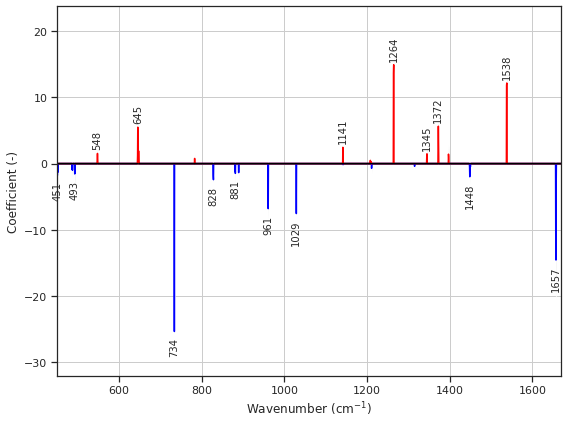

In [38]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=1, min_dist=50)

### Confusion Matrix

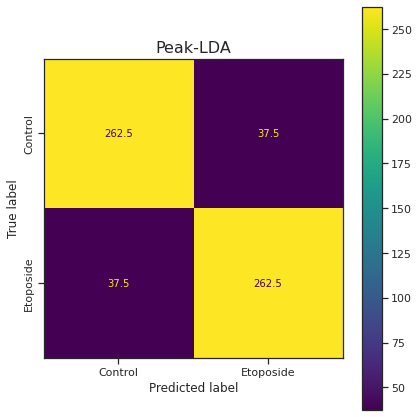

In [39]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

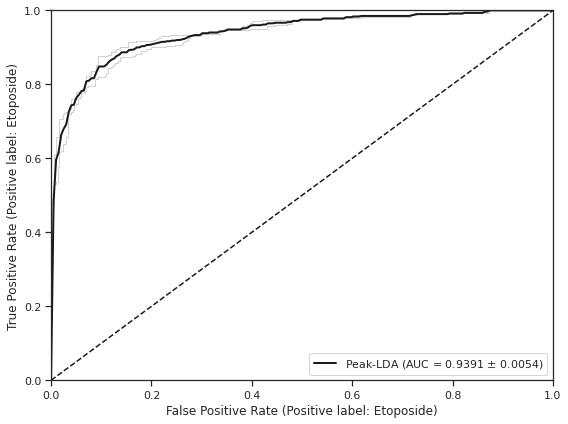

In [40]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Comparison of LDA with different dimensionality Reductions

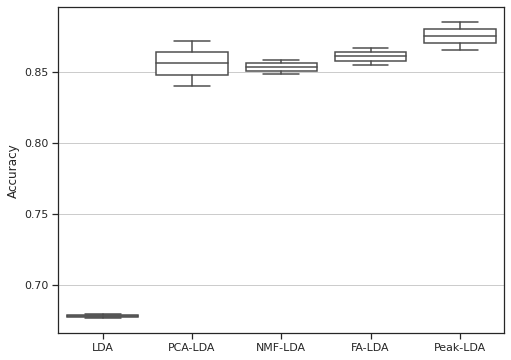

In [41]:
boxplot_comparison(accs, ylabel="Accuracy")

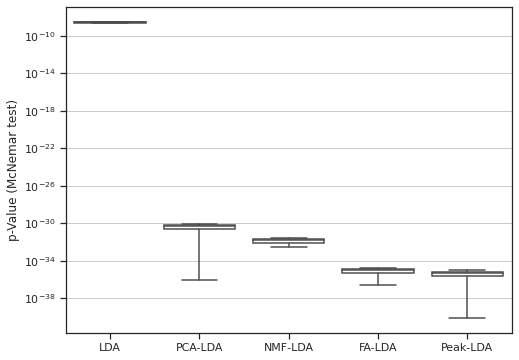

In [42]:
boxplot_comparison(p_vals, ylabel="p-Value (McNemar test)", log_scale=True)

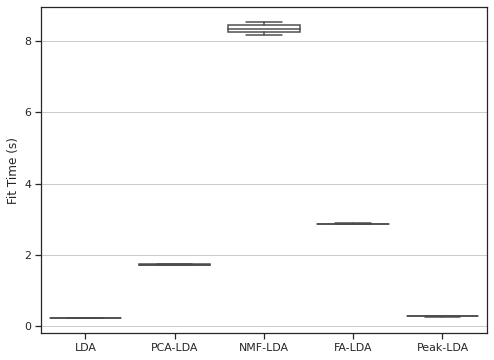

In [43]:
boxplot_comparison(fit_times, ylabel="Fit Time (s)")

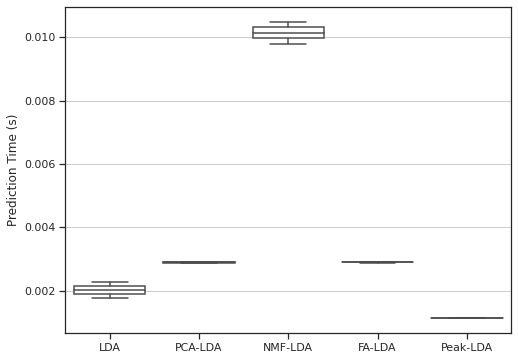

In [44]:
boxplot_comparison(predict_times, ylabel="Prediction Time (s)")

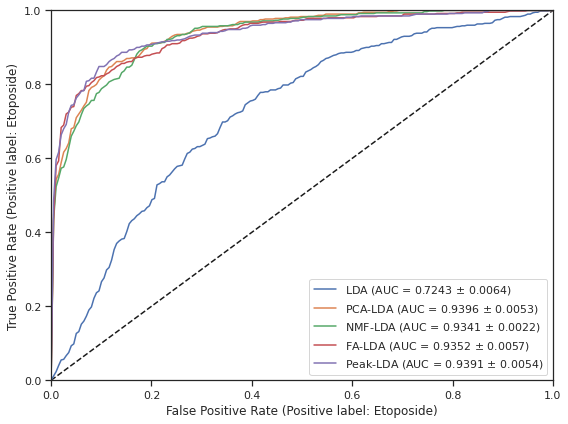

In [45]:
plot_roc_comparison(rocs, aucs, labels=y_key)

# Regularized Models
## Logistic Regression (l1)
### Overview

In [92]:
current_path = results_path / "regularized_models/logreg_l1/"
name = "Log. Reg. (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
mean,0.943750,0.886667,0.943437,0.887105,0.984111,0.952056,2.007349,0.003542,1.866974e-39
std,0.011785,0.004714,0.011926,0.004340,0.005249,0.005814,0.091612,0.000027,2.598071e-39
min,0.935417,0.883333,0.935003,0.884036,0.980399,0.947944,1.942569,0.003523,2.985992e-41
25%,0.939583,0.885000,0.939220,0.885570,0.982255,0.950000,1.974959,0.003532,9.484168e-40
50%,0.943750,0.886667,0.943437,0.887105,0.984111,0.952056,2.007349,0.003542,1.866974e-39
75%,0.947917,0.888333,0.947653,0.888639,0.985967,0.954111,2.039738,0.003552,2.785531e-39
max,0.952083,0.890000,0.951870,0.890173,0.987823,0.956167,2.072128,0.003561,3.704088e-39


### Validation Curve

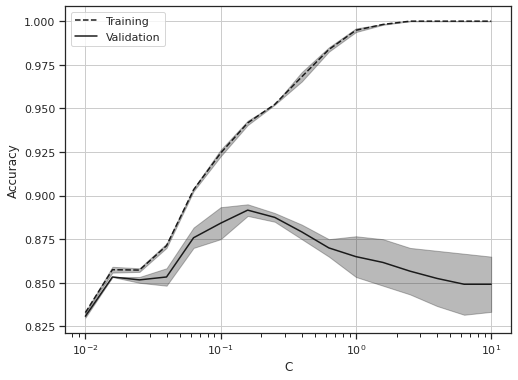

In [93]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

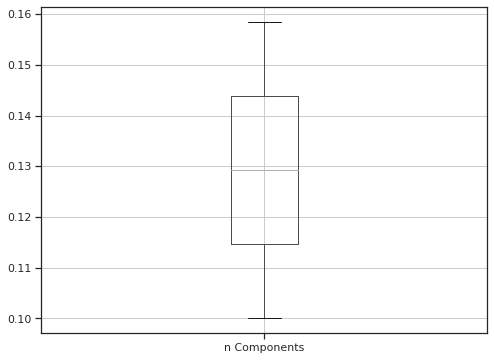

In [94]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

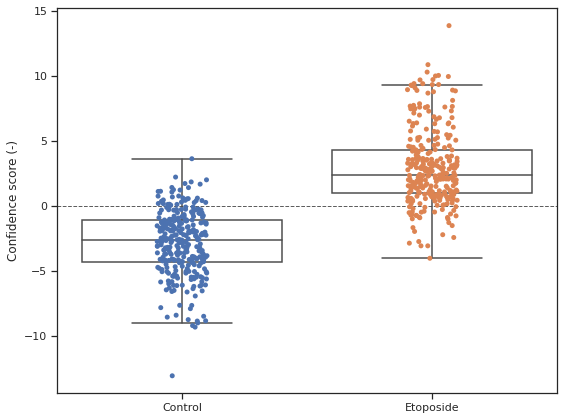

In [95]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

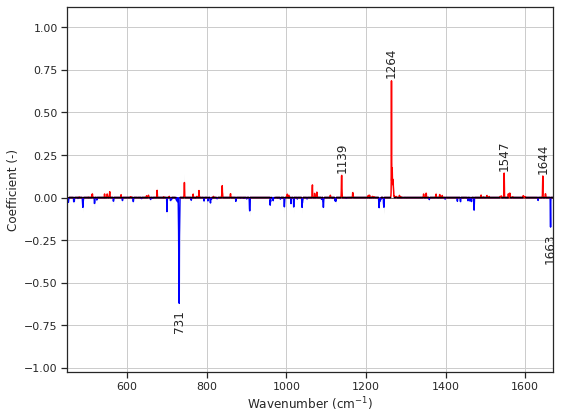

In [96]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

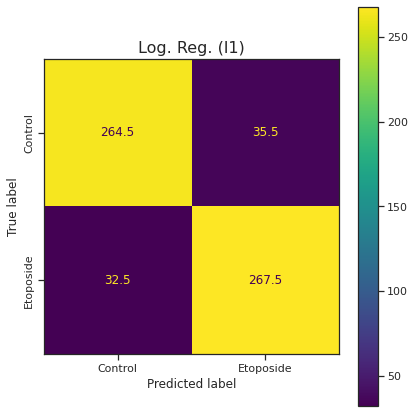

In [97]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

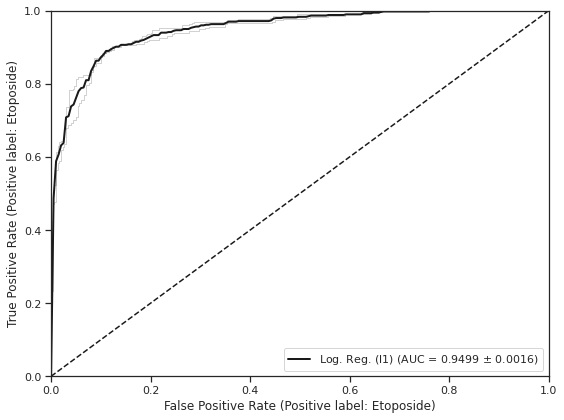

In [98]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Logistic Regression (l2)
### Overview

In [99]:
current_path = results_path / "regularized_models/logreg_l2/"
name = "Log. Reg. (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
mean,0.960417,0.850833,0.960221,0.849368,0.989377,0.941333,3.089386,0.003327,5.055788e-33
std,0.010017,0.008250,0.009703,0.007859,0.001775,0.002593,0.226887,0.000045,7.122032e-33
min,0.953333,0.845000,0.953360,0.843811,0.988122,0.939500,2.928953,0.003295,1.975147e-35
25%,0.956875,0.847917,0.956790,0.846590,0.988749,0.940417,3.009169,0.003311,2.537770e-33
50%,0.960417,0.850833,0.960221,0.849368,0.989377,0.941333,3.089386,0.003327,5.055788e-33
75%,0.963958,0.853750,0.963651,0.852147,0.990004,0.942250,3.169602,0.003343,7.573807e-33
max,0.967500,0.856667,0.967081,0.854925,0.990632,0.943167,3.249819,0.003359,1.009183e-32


### Validation Curve

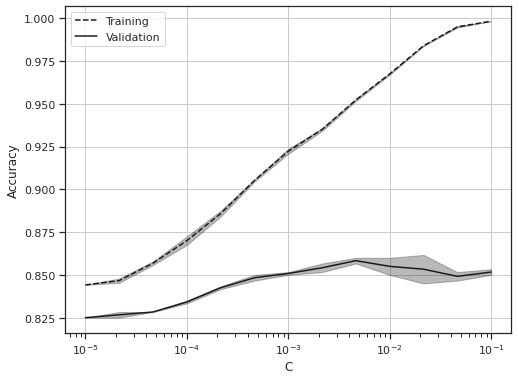

In [100]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

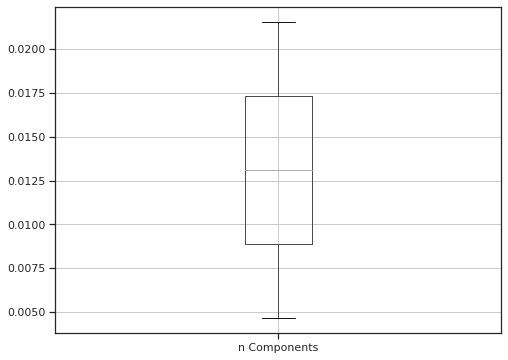

In [101]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

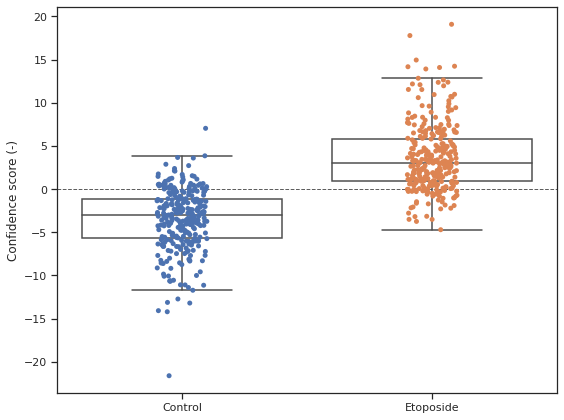

In [102]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

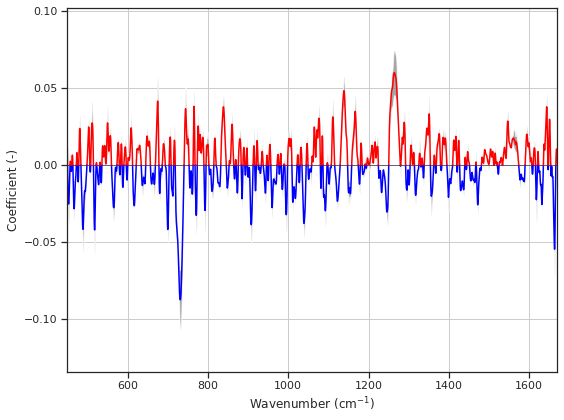

In [103]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

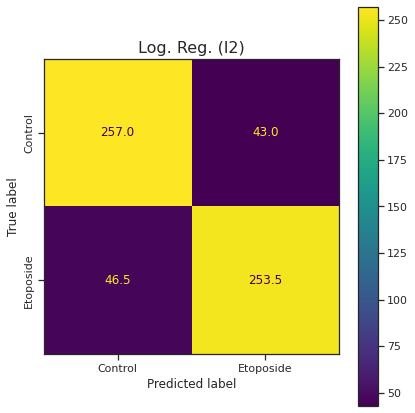

In [104]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

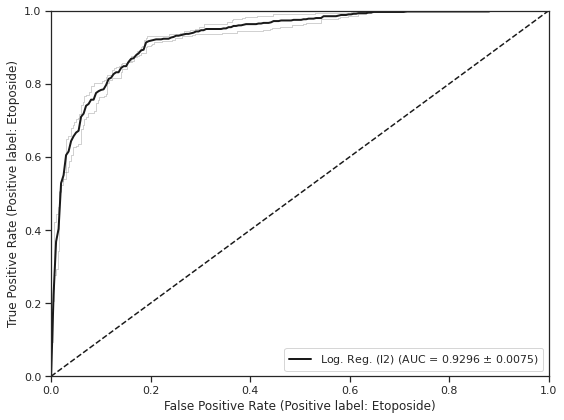

In [105]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Support Vector Machine (l1)
### Overview

In [106]:
current_path = results_path / "regularized_models/svm_l1/"
name = "SVM (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
mean,0.953542,0.880000,0.953292,0.880489,0.988069,0.951694,6.744148,0.004433,5.868431e-38
std,0.007955,0.007071,0.007955,0.007165,0.004385,0.008053,0.011040,0.001501,8.241072e-38
min,0.947917,0.875000,0.947667,0.875423,0.984969,0.946000,6.736342,0.003372,4.111232e-40
25%,0.950729,0.877500,0.950480,0.877956,0.986519,0.948847,6.740245,0.003903,2.954771e-38
50%,0.953542,0.880000,0.953292,0.880489,0.988069,0.951694,6.744148,0.004433,5.868431e-38
75%,0.956354,0.882500,0.956104,0.883022,0.989620,0.954542,6.748051,0.004964,8.782090e-38
max,0.959167,0.885000,0.958917,0.885556,0.991170,0.957389,6.751954,0.005495,1.169575e-37


### Validation Curve

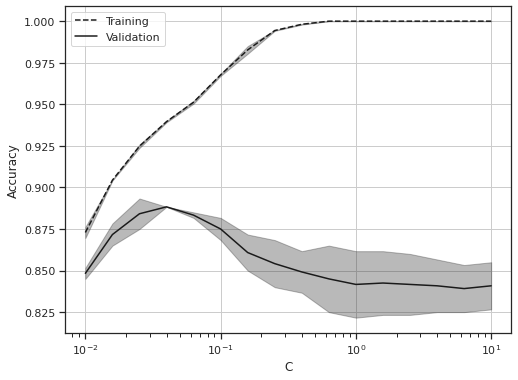

In [107]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

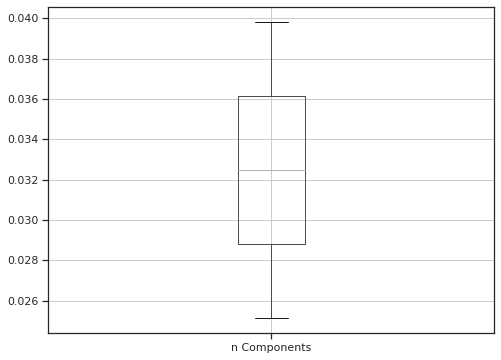

In [108]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

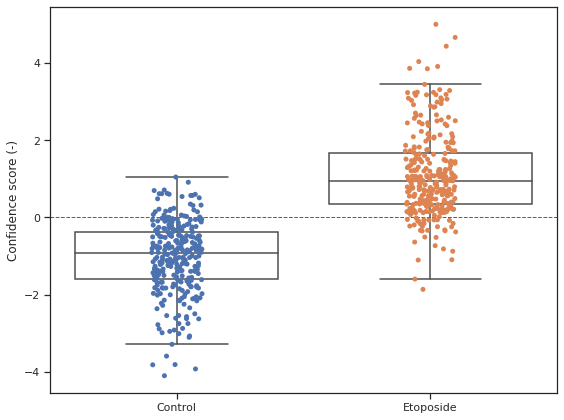

In [109]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

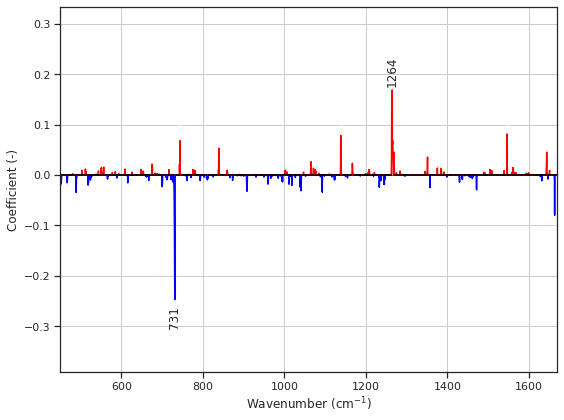

In [110]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

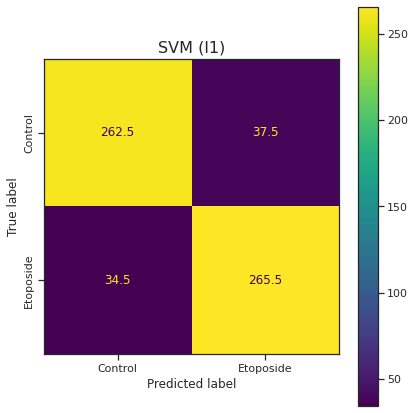

In [111]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

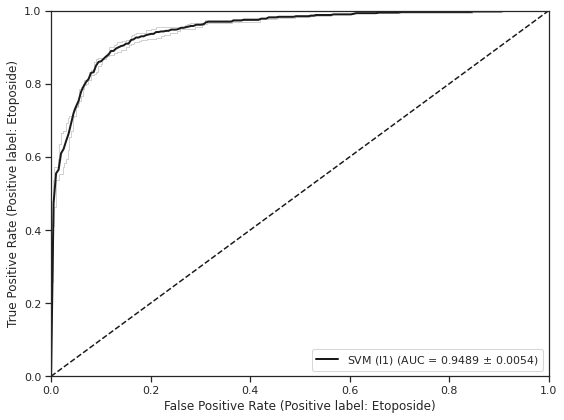

In [112]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Support Vector Machine (l2)
### Overview

In [113]:
current_path = results_path / "regularized_models/svm_l2/"
name = "SVM (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
mean,0.965417,0.847500,0.965711,0.846410,0.993083,0.938750,2.431807,0.003816,4.777268e-31
std,0.018856,0.017678,0.018774,0.016468,0.004159,0.007817,0.050526,0.000405,6.756039e-31
min,0.952083,0.835000,0.952436,0.834765,0.990142,0.933222,2.396080,0.003529,2.654864e-36
25%,0.958750,0.841250,0.959074,0.840587,0.991613,0.935986,2.413943,0.003673,2.388647e-31
50%,0.965417,0.847500,0.965711,0.846410,0.993083,0.938750,2.431807,0.003816,4.777268e-31
75%,0.972083,0.853750,0.972349,0.852232,0.994554,0.941514,2.449671,0.003960,7.165888e-31
max,0.978750,0.860000,0.978986,0.858054,0.996024,0.944278,2.467535,0.004103,9.554509e-31


### Validation Curve

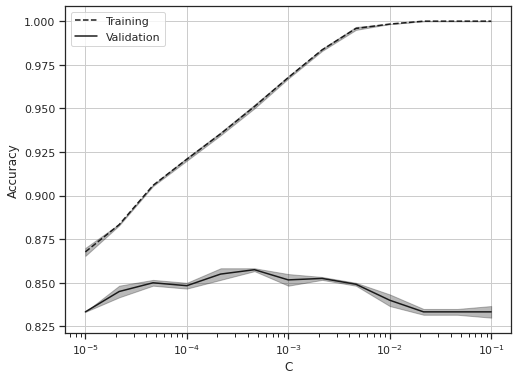

In [114]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

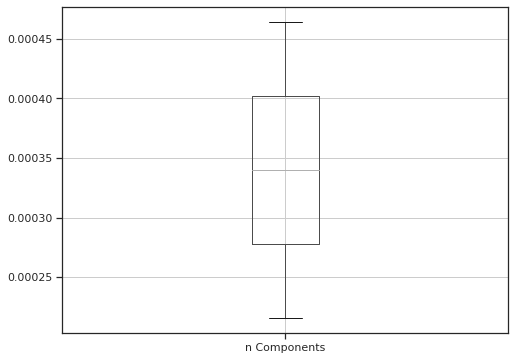

In [115]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

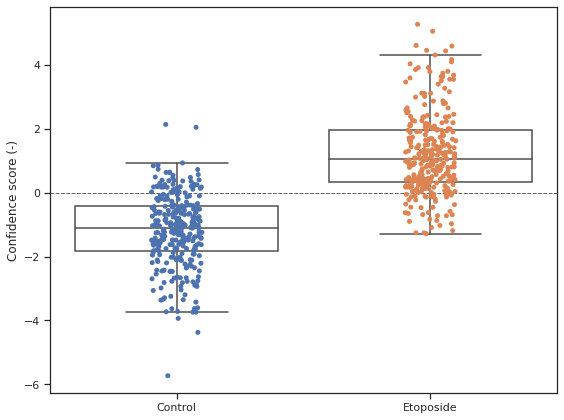

In [116]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

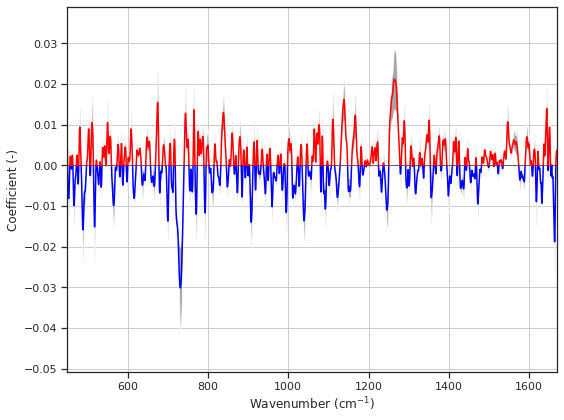

In [117]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

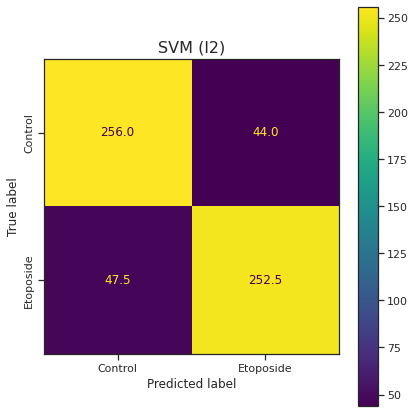

In [118]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

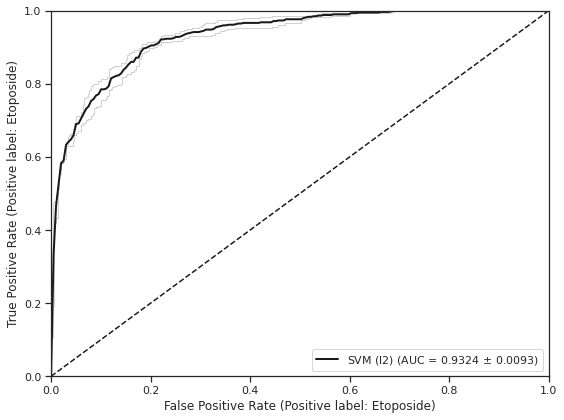

In [119]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Decision Tree
### Overview

In [120]:
current_path = results_path / "tree_based_models/decision_tree/"
name = "Decision Tree"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
mean,0.923958,0.864167,0.921374,0.857858,0.945541,0.887514,4.397862,0.001971,2.157532e-38
std,0.015615,0.008250,0.015817,0.009353,0.015720,0.001473,0.011502,0.000010,2.938562e-38
min,0.912917,0.858333,0.910189,0.851244,0.934425,0.886472,4.389729,0.001964,7.965503e-40
25%,0.918438,0.861250,0.915781,0.854551,0.939983,0.886993,4.393795,0.001968,1.118593e-38
50%,0.923958,0.864167,0.921374,0.857858,0.945541,0.887514,4.397862,0.001971,2.157532e-38
75%,0.929479,0.867083,0.926966,0.861164,0.951099,0.888035,4.401929,0.001975,3.196470e-38
max,0.935000,0.870000,0.932558,0.864471,0.956656,0.888556,4.405995,0.001979,4.235409e-38


### Validation Curve

In [121]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

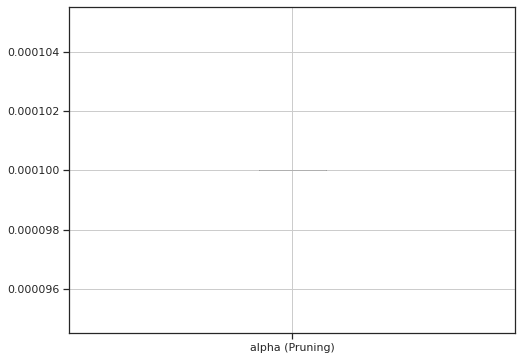

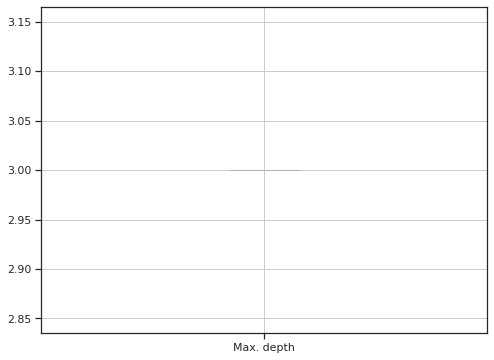

In [122]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels=["alpha (Pruning)", "Max. depth"])

### Confidence scores by class

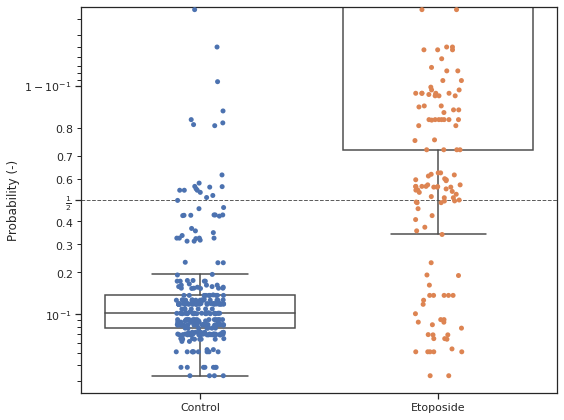

In [123]:
conf_score_df = pd.read_csv(current_path / "probabilities.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key, scale="logit")

### Tree

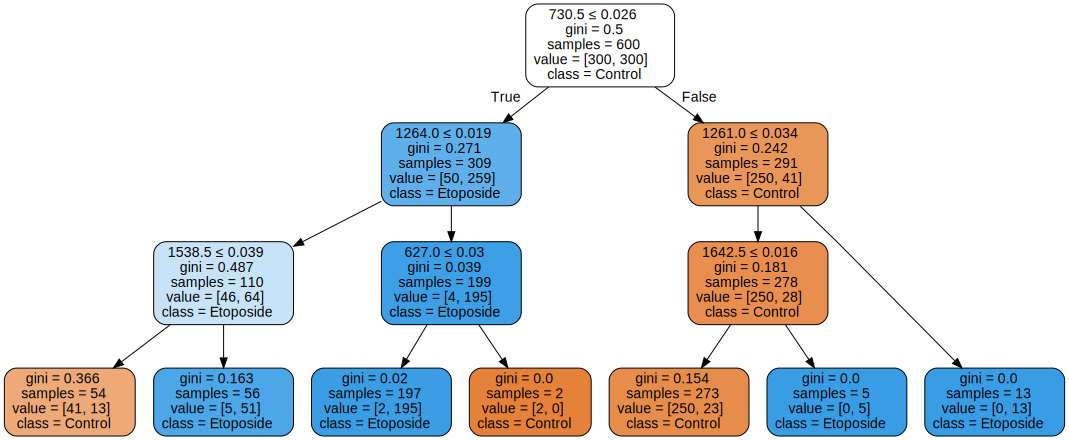

In [124]:
graphviz.Source.from_file(current_path / "tree.dot")

### Confusion Matrix

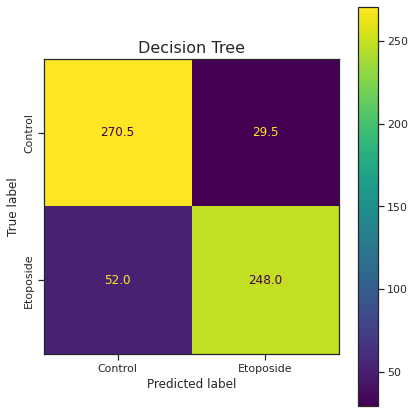

In [125]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

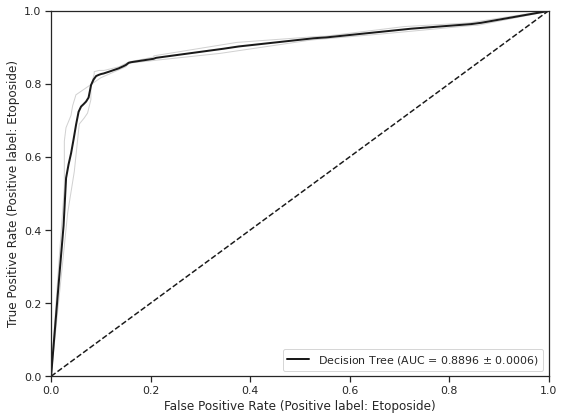

In [126]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Random Forest
### Overview

In [127]:
current_path = results_path / "tree_based_models/random_forest/"
name = "Random Forest"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
mean,0.918542,0.878333,0.915149,0.872197,0.979852,0.949278,1.890738,0.002783,7.907972e-42
std,0.001473,0.011785,0.001656,0.014811,0.000101,0.003693,0.019104,0.000598,1.101449e-41
min,0.917500,0.870000,0.913978,0.861724,0.979781,0.946667,1.877230,0.002360,1.195537e-43
25%,0.918021,0.874167,0.914564,0.866961,0.979817,0.947972,1.883984,0.002571,4.013763e-42
50%,0.918542,0.878333,0.915149,0.872197,0.979852,0.949278,1.890738,0.002783,7.907972e-42
75%,0.919063,0.882500,0.915734,0.877434,0.979888,0.950583,1.897492,0.002994,1.180218e-41
max,0.919583,0.886667,0.916319,0.882670,0.979924,0.951889,1.904247,0.003206,1.569639e-41


### Validation Curve

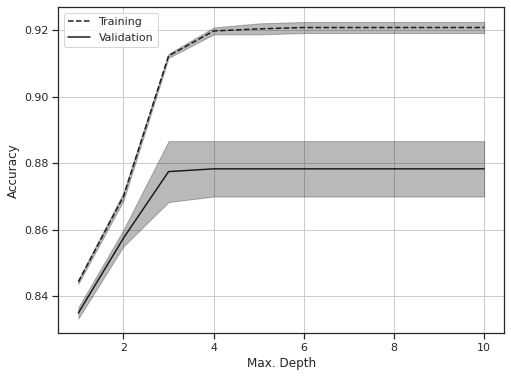

In [128]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Max. Depth", y_label="Accuracy")

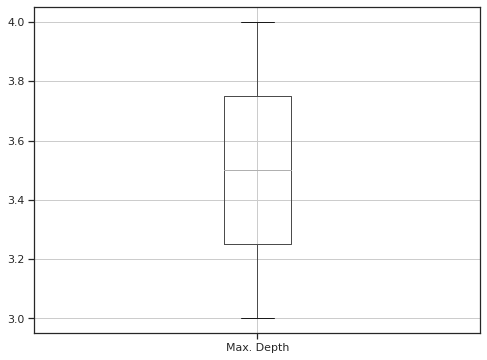

In [129]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="Max. Depth")

### Confidence scores by class

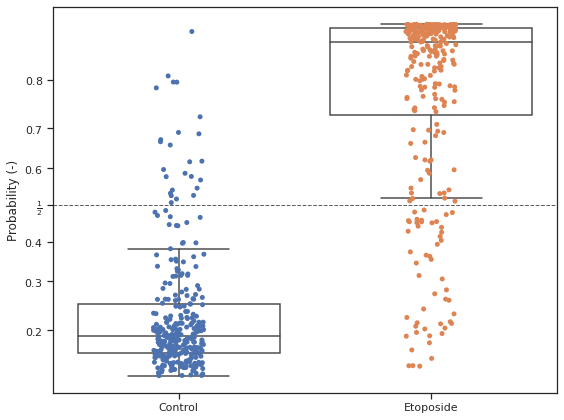

In [130]:
conf_score_df = pd.read_csv(current_path / "probabilities.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key, scale="logit")

### Confusion Matrix

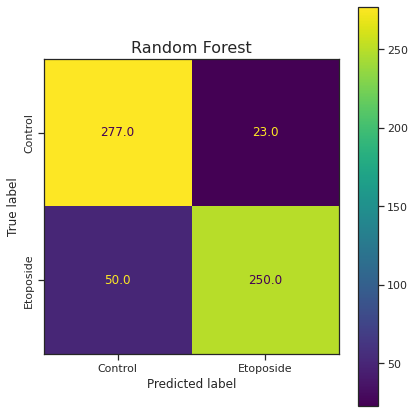

In [131]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

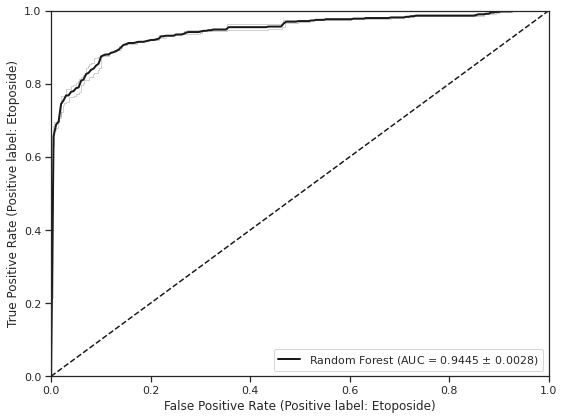

In [132]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Gradient Boosted Trees
### Overview

In [133]:
current_path = results_path / "tree_based_models/gbdt/"
name = "Gradient-boosted Trees"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc,fit_time,predict_time,p_value
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
mean,0.995208,0.898333,0.995117,0.893800,0.999507,0.963639,1.654885,0.004528,4.679197e-46
std,0.006776,0.002357,0.006906,0.004667,0.000697,0.000982,0.031774,0.003445,1.556469e-46
min,0.990417,0.896667,0.990234,0.890500,0.999014,0.962944,1.632418,0.002092,3.578607e-46
25%,0.992813,0.897500,0.992675,0.892150,0.999260,0.963292,1.643652,0.003310,4.128902e-46
50%,0.995208,0.898333,0.995117,0.893800,0.999507,0.963639,1.654885,0.004528,4.679197e-46
75%,0.997604,0.899167,0.997558,0.895450,0.999753,0.963986,1.666119,0.005746,5.229492e-46
max,1.000000,0.900000,1.000000,0.897100,1.000000,0.964333,1.677353,0.006964,5.779786e-46


### Validation Curve

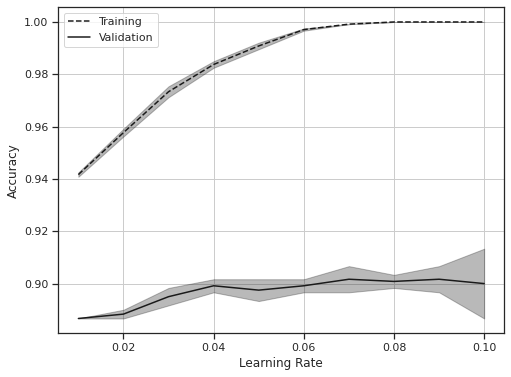

In [134]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Learning Rate", y_label="Accuracy")

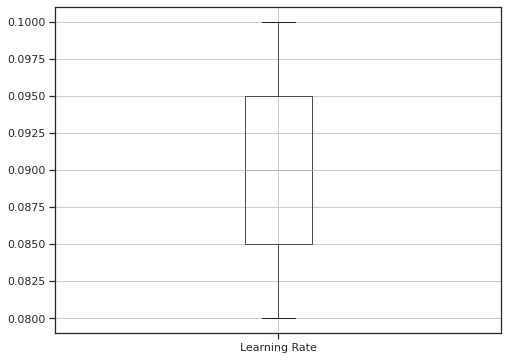

In [135]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="Learning Rate")

### Confidence scores by class

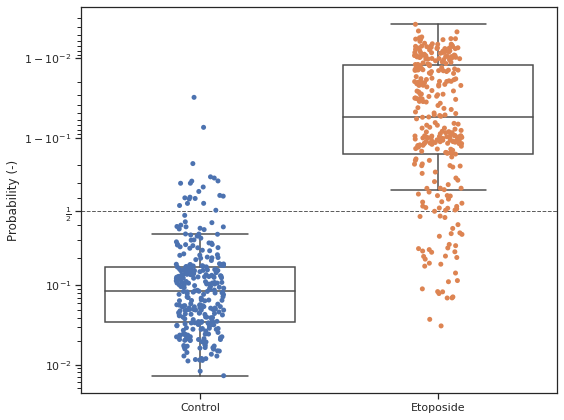

In [136]:
conf_score_df = pd.read_csv(current_path / "probabilities.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key, scale="logit")

### Confusion Matrix

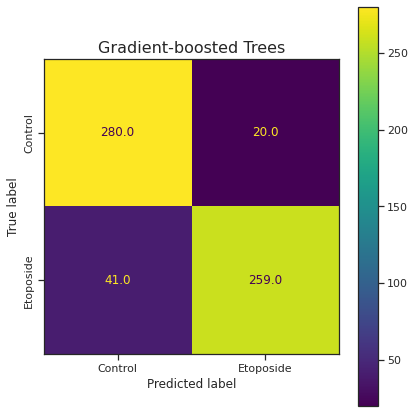

In [137]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

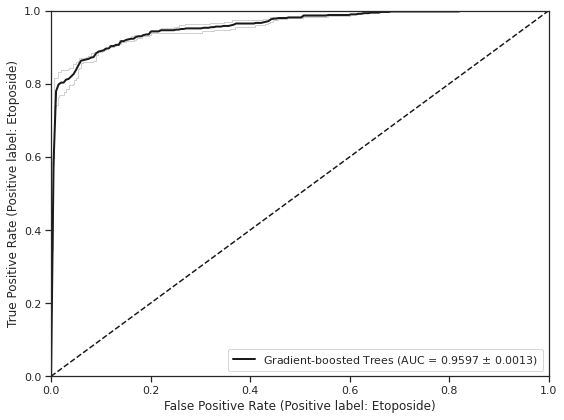

In [138]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc